In [1]:
# System
import os
import sys
import inspect
import tabulate
import time

# Data processing
import numpy as np
import math as m

# Results presentation
from tqdm import tqdm as tqdm
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import data
import models
import utils
import correlation
import regularization

%matplotlib inline

In [2]:
class GlobalArguments():
    
    def __init__(self):
        self.model       = 'TwoLayersNet'
        self.dataset     = 'CIFAR100'
        self.data_path   = '../Data/'
        self.batch_size  = 128
        self.num_workers = 4
        self.transform   = 'VGG'
        self.use_test    = True
        self.models_path = 'Checkpoints/'
        self.n_models    = 40
        self.boost_ckpts = '../Checkpoints/FGE/CIFAR100/TwoLayers/ind_grad_boost/classic/lr_auto/0.01-0.0001_200_0/'
        self.new_model   = '../Checkpoints/FGE/CIFAR100/TwoLayers/ind_grad_boost/classic/lr_auto/0.01-0.0001_200_0/fge-499.pt'
        self.device      = 1
args = GlobalArguments()

In [3]:
device = 'cuda:' + str(args.device) if torch.cuda.is_available() else 'cpu'
torch.cuda.set_device(device)

In [4]:
if   args.dataset == "CIFAR10":
    num_classes = 10
elif args.dataset == "CIFAR100":
    num_classes = 100

architecture = getattr(models, args.model)

In [5]:
ens_models = []
models_weights  = []
# indicies = range (690, 1011, 20)
# indicies = [i for i in range (349, 2600, 150)]
# indicies.insert(0, 200)
indicies = [200, 299, 399]
print (indicies)

for i in tqdm(indicies):
    model = architecture.base(num_classes=num_classes, **architecture.kwargs)
    checkpoint = torch.load(args.boost_ckpts + 'fge-' + str(i) + '.pt', map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state'])
    ens_models.append(model)
    models_weights .append(checkpoint['boost_weight'])

 67%|██████▋   | 2/3 [00:00<00:00, 13.31it/s]

[200, 299, 399]


100%|██████████| 3/3 [00:00<00:00, 13.24it/s]


In [6]:
loaders, num_classes = data.loaders_gb(
    args.dataset,
    args.data_path,
    args.batch_size,
    args.num_workers,
    args.transform,
    args.use_test,
    shuffle_train=False,
    logits_generator=regularization.dataset_logits_generator(
        ens_models[0].cuda(),
        transform=getattr(getattr(data.Transforms, args.dataset), args.transform).train,
        batch_size=args.batch_size),
)
assert models_weights[0] == 1.

Files already downloaded and verified
Initial logits :
Shape : torch.Size([50000, 100]) Logits_mean : 0.011970081366598606
Max : 86.42589569091797 Min : -95.51688385009766
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


In [7]:
for iter in tqdm(range(1, len(ens_models))):
    loaders['train'].dataset.update_logits(
        models_weights[iter],
        logits_generator=regularization.dataset_logits_generator(
            ens_models[iter].cuda(),
            transform=getattr(getattr(
                    data.Transforms,
                    args.dataset),
                args.transform).train,
            batch_size = args.batch_size))
        
    loaders['test'].dataset.update_logits(
        models_weights[iter],
        logits_generator=regularization.dataset_logits_generator(
            ens_models[iter].cuda(),
            transform=getattr(getattr(
                    data.Transforms,
                    args.dataset),
                args.transform).test,
            batch_size = args.batch_size))

100%|██████████| 2/2 [00:31<00:00, 15.85s/it]


In [8]:
new_model = architecture.base(num_classes=num_classes, **architecture.kwargs)
checkpoint = torch.load(args.new_model, map_location=torch.device('cpu'))
new_model.load_state_dict(checkpoint['model_state'])
new_model_weight = checkpoint['boost_weight']

In [9]:
def outputs_logits_labels(model, dataloader, device=torch.device('cpu')):
    with torch.no_grad():
        model.to(device)
        output_list = []
        logits_list = []
        labels_list = []
        antigr_list = []
        for input, labels, logits in dataloader:
            input  = input .to(device)
            logits = logits.to(device)
            labels = labels.to(device)

            antigr = utils.one_hot(labels, logits.shape[1]) - F.softmax(logits, dim=1)
            output = model(input)

            output_list.append(output.cpu())
            logits_list.append(logits.cpu())
            labels_list.append(labels.cpu())
            antigr_list.append(antigr.cpu())

        output_list = torch.cat(output_list, dim=0)
        logits_list = torch.cat(logits_list, dim=0)
        labels_list = torch.cat(labels_list, dim=0)
        antigr_list = torch.cat(antigr_list, dim=0)
    return output_list, logits_list, labels_list, antigr_list

def loss_acc_dependency (model, dataloader, device=torch.device('cpu'), start_pow=-6, fin_pow=3, n_dots=1000):
    criterion = torch.nn.CrossEntropyLoss()
    output_train, logits_train, labels_train, antigr_train = outputs_logits_labels(
        model,
        loaders['train'],
        device=device)
                
    output_test, logits_test, labels_test, antigr_test = outputs_logits_labels(
        model,
        loaders['test'],
        device=device)
    
    res = {}
    res["coefs"] = 10 ** np.linspace(start_pow, fin_pow, n_dots)
    res["train_loss"] = []
    res["test_loss"]  = []
    res["train_gr_loss"] = []
    res["test_gr_loss"] = []
    res["train_acc"]  = []
    res["test_acc"]   = []
    
    with torch.no_grad():
        for coef in tqdm(res["coefs"]):
            pred_train = logits_train + coef * output_train
            pred_test  = logits_test  + coef * output_test
            pred_gr_train = logits_train + coef * antigr_train
            pred_gr_test  = logits_test  + coef * antigr_test
            
            res["train_loss"].append(
                criterion(pred_train, labels_train).item())
            res["test_loss"].append(
                criterion(pred_test , labels_test ).item())
            res["train_gr_loss"].append(
                criterion(pred_gr_train, labels_train).item())
            res["test_gr_loss"].append(
                criterion(pred_gr_test , labels_test).item())
            res["train_acc"].append(
                torch.eq(pred_train.argmax(dim=1), labels_train).float().mean().item())
            res["test_acc"].append(
                torch.eq(pred_test .argmax(dim=1), labels_test) .float().mean().item())
    return res


        

In [21]:
def draw_figures(table, predicted=None, filename=None):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    nrows=3, ncols=2,
    figsize=(10, 15))
    
    ax1.plot(table['coefs'], table['train_loss'])
    ax1.set_title('Train Loss')
    ax1.set_xlabel('Boost_lr')
#     ax1.set_ylabel('Train Loss')
    ax1.set_xscale('log')
    if predicted is not None:
        ax1.axvline(predicted, c='r')
    
    ax2.plot(table['coefs'], table['test_loss'])
    ax2.set_title('Test Loss')
    ax2.set_xlabel('Boost_lr')
#     ax2.set_ylabel('Test Loss')
    ax2.set_xscale('log')
    if predicted is not None:
        ax2.axvline(predicted, c='r')
    
    ax3.plot(table['coefs'], table['train_gr_loss'])
    ax3.set_title('Train Grad Loss')
    ax3.set_xlabel('Boost_lr')
#     ax3.set_ylabel('Train accuracy')
    ax3.set_xscale('log')
    if predicted is not None:
        ax3.axvline(predicted, c='r')
    
    ax4.plot(table['coefs'], table['test_gr_loss'])
    ax4.set_title('Test Grad Loss')
    ax4.set_xlabel('Boost_lr')
#     ax4.set_ylabel('Test accuracy')
    ax4.set_xscale('log')
    if predicted is not None:
        ax4.axvline(predicted, c='r')
        
    ax5.plot(table['coefs'], table['train_acc'])
    ax5.set_title('Train accuracy')
    ax5.set_xlabel('Boost_lr')
#     ax3.set_ylabel('Train accuracy')
    ax5.set_xscale('log')
    if predicted is not None:
        ax5.axvline(predicted, c='r')
    
    ax6.plot(table['coefs'], table['test_acc'])
    ax6.set_title('Test accuracy')
    ax6.set_xlabel('Boost_lr')
#     ax4.set_ylabel('Test accuracy')
    ax6.set_xscale('log')
    if predicted is not None:
        ax6.axvline(predicted, c='r')
    
    if filename is not None:
        plt.savefig(filename + '.png')

In [23]:
table = loss_acc_dependency(new_model, loaders, device=torch.device('cuda'), start_pow=-1, fin_pow=4)

100%|██████████| 1000/1000 [00:26<00:00, 37.28it/s]


4.090334415435791


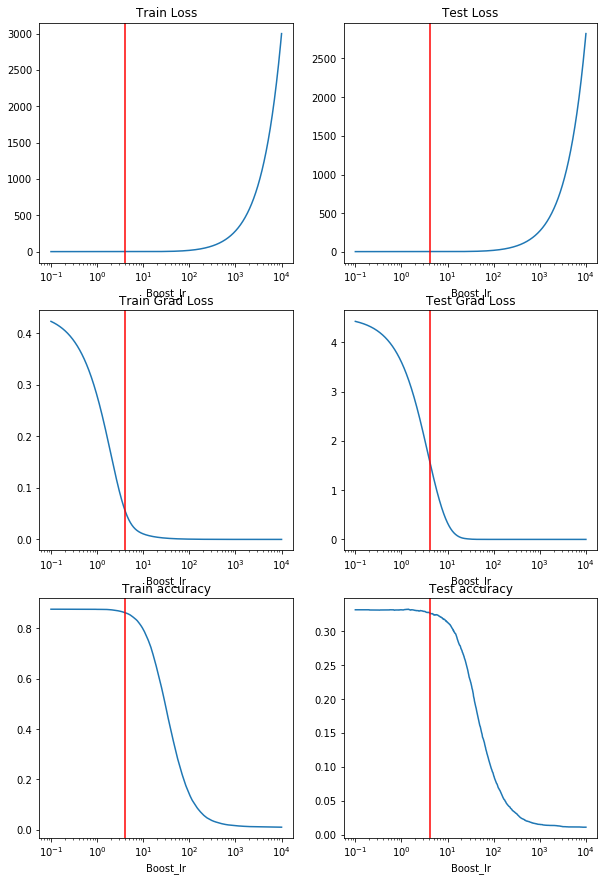

In [24]:
print(new_model_weight)
draw_figures(table, predicted=new_model_weight)

In [16]:
adj_process = torch.load(args.boost_ckpts + '/boost_lr/199.pt')
print (adj_process.keys())

dict_keys(['iter', 'loss', 'lr', 'grad'])


In [25]:
def draw_figures_blr(table, predicted=None, filename=None):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2, ncols=2,
    figsize=(10, 10))
    
    ax1.plot(table['iter'], table['loss'])
    ax1.set_title('Loss')
    ax1.set_xlabel('iter')
#     ax1.set_ylabel('Train Loss')
#     ax1.set_xscale('log')
    
    ax2.plot(table['iter'], table['lr'])
    ax2.set_title('Learning rate')
    ax2.set_xlabel('iter')
#     ax2.set_ylabel('Test Loss')
#     ax2.set_xscale('log')
    
    ax3.plot(table['iter'], table['grad'])
    ax3.set_title('Gradient')
    ax3.set_xlabel('iter')
#     ax3.set_ylabel('Train accuracy')
#     ax3.set_xscale('log')
    
    if filename is not None:
        plt.savefig(filename + '.png')

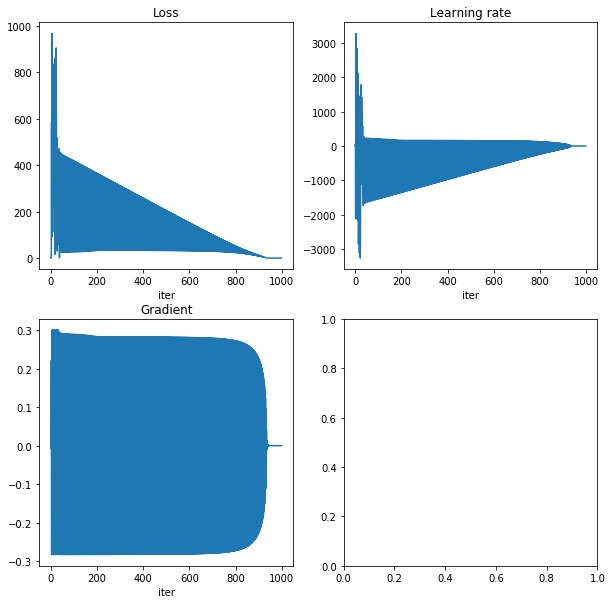

In [26]:
draw_figures_blr(adj_process)